In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from scipy import stats
import pickle

In [23]:
import os
filenames = sorted(os.listdir('experiments'))

def exp_name(exp):
    if exp[0] == exp[1]:
        return "{}, {} days".format(exp[0],exp[2])
    else:
        return "{}-of-{}, {} days".format(exp[0],exp[1],exp[2])

experiment_map = {'2-2-3.pkl': [2,2,3],
                  '3-4-3.pkl': [3,4,3],
                  '6-8-3.pkl': [6,8,3],
                  '2-2-14.pkl':[2,2,14],
                  '3-4-14.pkl':[3,4,14],
                  '6-8-14.pkl':[6,8,14]}


experiments = {}

for filename in filenames:
#     df = parse_results(filename, with_header=True)
    try:
        f = open('experiments/'+filename, "rb")
        results = pickle.load(f)
        f.close
        print('nb experiments for {}: {}'.format(filename, len(results)))
        experiments[filename] = results
    except:
        print('parsing failed for {}'.format(filename))
        continue

nb experiments for 2-2-14.pkl: 1000
nb experiments for 2-2-3.pkl: 1000
nb experiments for 3-4-14.pkl: 1000
nb experiments for 3-4-3.pkl: 1000
nb experiments for 6-8-14.pkl: 1000
nb experiments for 6-8-3.pkl: 1000
parsing failed for best_guess_deanonymisation_1.5.png


In [35]:
statistics = {'nb_movies':[], 'days':[], 'proba':[]}
for filename, results in experiments.items():
    print('experiment {}'.format(exp_name(experiment_map[filename])))
    print(sum([r['id'] == r['matchedId'] for r in results])/len(results))
    succ_thresh = sum([(r['id'] == r['matchedId'])&(r['eccentricity']>=0.13) for r in results])/len(results)
    print(succ_thresh)
    l = experiment_map[filename]
    statistics['nb_movies'].append('{}-{}'.format(l[0],l[1]))
    statistics['days'].append(l[2])
    statistics['proba'].append(succ_thresh)

experiment 2, 14 days
0.432
0.392
experiment 2, 3 days
0.68
0.606
experiment 3-of-4, 14 days
0.773
0.733
experiment 3-of-4, 3 days
0.906
0.87
experiment 6-of-8, 14 days
0.986
0.977
experiment 6-of-8, 3 days
0.996
0.993


[Text(0, 0.5, 'Probability of deanonymisation'),
 Text(0.5, 0, 'Aux: number of movies')]

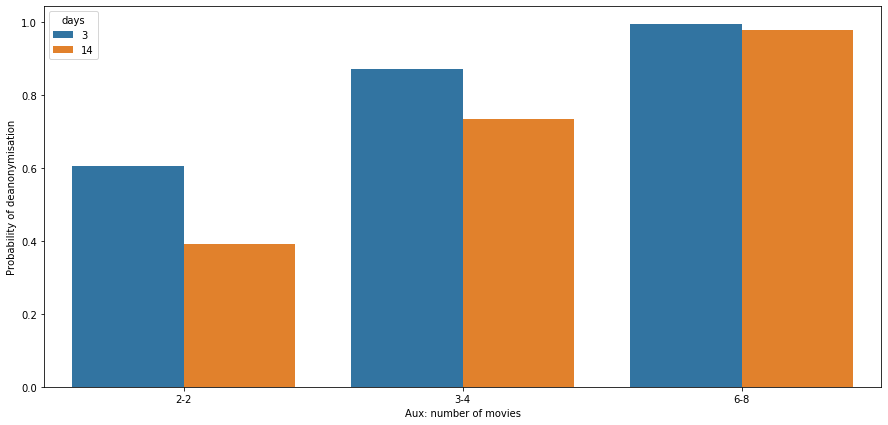

In [36]:
df = pd.DataFrame(statistics)#.set_index(['nb_movies', 'days']).unstack()
plt.figure(figsize=(15,7))
ax = sns.barplot(x='nb_movies', y='proba', hue='days', data=df)
ax.set(xlabel='Aux: number of movies', ylabel='Probability of deanonymisation')

Text(0, 0.5, 'True positive rate')

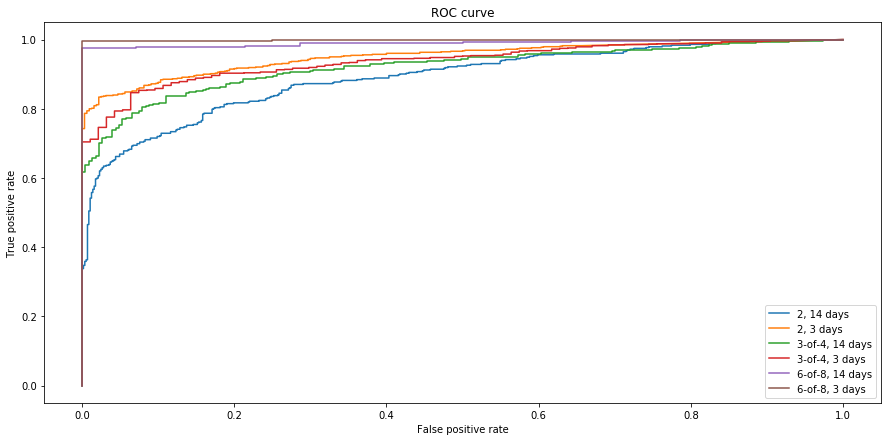

In [29]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,7))
    
for exp, results in experiments.items():
    y_true = [(r['id'] == r['matchedId']) for r in results]
    y_score = [r['eccentricity'] for r in results]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    plt.plot(fpr, tpr, label=exp_name(experiment_map[exp]))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

Text(0, 0.5, 'Probability')

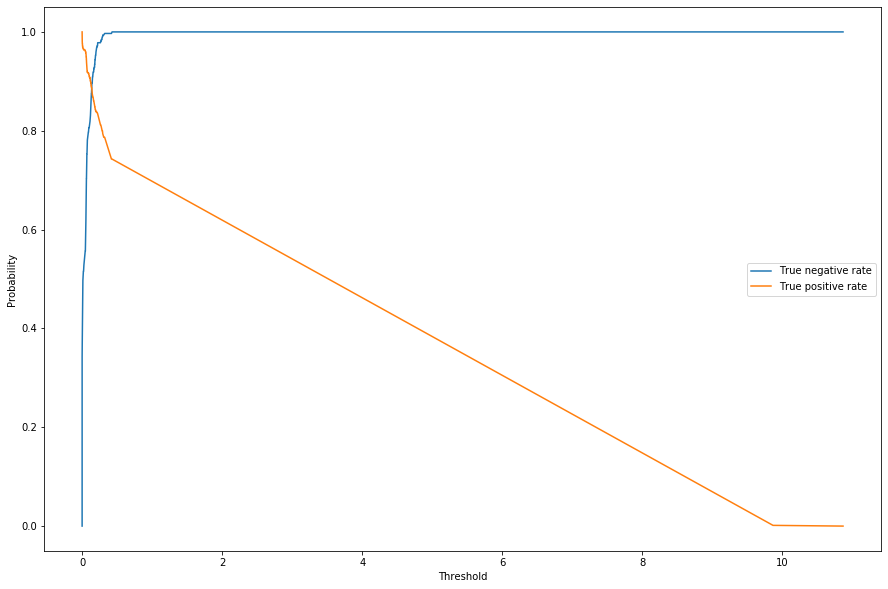

In [33]:
plt.figure(figsize=(15,10))

results = experiments['2-2-3.pkl']

y_true = [(r['id'] == r['matchedId']) for r in results]
y_score = [r['eccentricity'] for r in results]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
plt.plot(thresholds, 1 - fpr, label="True negative rate")
plt.plot(thresholds, tpr, label="True positive rate")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Probability")

In [42]:
# thresholds are in reverse order
for tpr_, fpr_, thresh in reversed(list(zip(tpr, fpr, thresholds))):
    if 1-fpr_ > tpr_:
        print("{} | {} => {}".format(tpr_, fpr_, thresh))
        break

0.8852941176470588 | 0.10625 => 0.13828158572264154
